<a href="https://colab.research.google.com/github/Himanshu-Dharma/master-thesis-feature-extraction-and-sentiment-analysis-using-deep-learning/blob/main/Thesis_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Description


1. **reviewerID** - ID of the reviewer, e.g. A2SUAM1J3GNN3B
2. **asin** - ID of the product, e.g. 0000013714
3. **reviewerName** - name of the reviewer
4. **vote** - helpful votes of the review
5. **style** - a disctionary of the product metadata, e.g., "Format" is "Hardcover"
6. **reviewText** - text of the review
7. **overall** - rating of the product
8. **summary** - summary of the review
9. **unixReviewTime** - time of the review (unix time)
10. **reviewTime** - time of the review (raw)
11. **image** - images that users post after they have received the product

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# For Word Cloud
from wordcloud import WordCloud
from os import path
from PIL import Image

# For Data Preprocessing
import re
import nltk
import string
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Splitting dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Loading the data

In [ ]:
df_primary = pd.read_json("/content/drive/MyDrive/ThesisData/thesis_data_primary.json")

# Exploratory Data Analysis

In [ ]:
df_primary.head(2)

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5,90,False,"08 9, 2004",AXHY24HWOF184,0470536454,{'Format:': ' Paperback'},Bendy,Crocheting for Dummies by Karen Manthey & Susa...,Terrific Book for Learning the Art of Crochet,1092009600,NaN
1,4,2,True,"04 6, 2017",A29OWR79AM796H,0470536454,{'Format:': ' Hardcover'},Amazon Customer,Very helpful...,Four Stars,1491436800,NaN


## Checking for Null values

In [ ]:
#total number of rows and coluns in our dataset
df_primary.shape

(1512530, 12)

In [ ]:
#Total number of null values per column
df_primary.isnull().sum()

overall                 0
vote              1268582
verified                0
reviewTime              0
reviewerID              0
asin                    0
style              839992
reviewerName          150
reviewText            855
summary               380
unixReviewTime          0
image             1482365
dtype: int64

##Rating(star) Distribution

In [ ]:
df_overall = df_primary['overall'].value_counts()
df_overall = df_overall.reset_index()
df_overall.columns = ['Rating', 'Count']
df_overall

,Rating,Count
0,5,984097
1,4,237295
2,1,118102
3,3,106249
4,2,66787


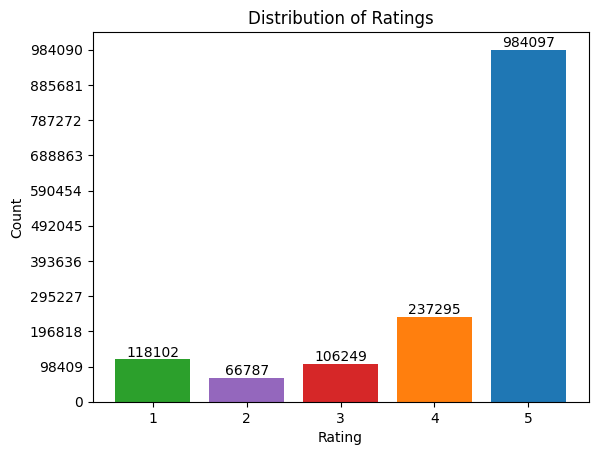

In [ ]:
plt.bar(df_overall['Rating'], df_overall['Count'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])

# Adding labels and title
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')

# Adding numbers on top of each bar
for i, value in enumerate(df_overall['Count']):
    plt.annotate(str(value), (df_overall['Rating'][i], value), ha='center', va='bottom')

# Setting the y-axis tick interval as the values in the data are > 100000
plt.yticks(range(0, max(df_overall['Count']), int(max(df_overall['Count'])/10)))

# Displaying the graph
plt.show()

## Word cloud

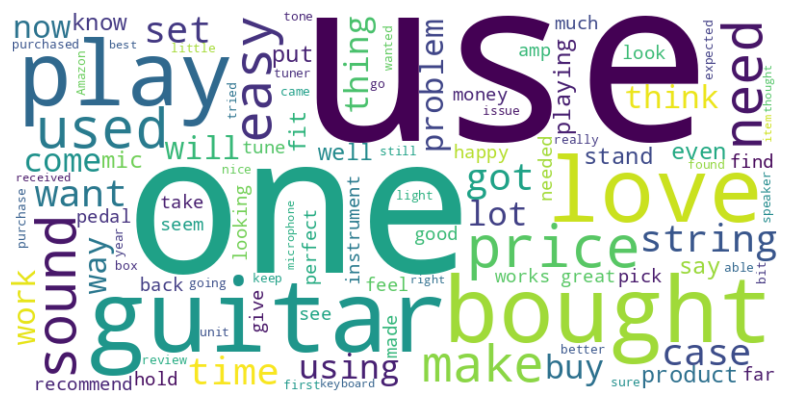

In [ ]:
#Word cloud
from wordcloud import WordCloud

#text column
df_primary['reviewText'] = df_primary['reviewText'].astype(str)
text_data = ' '.join(df_primary['reviewText'])

# Creating a WordCloud object
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(text_data)

# Displaying the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Unique product reviews



**112222** Unique products are reviewed, and most reviewed product contains **5082** reviews.

In [ ]:
products = df_primary.asin
products.value_counts()

B000VSM4MS    5082
B004XNK7AI    4704
B00IFOTSJW    4110
B000XI6O2W    3924
B00XQFONF4    3901
              ... 
B00GFRHD5W       1
B00GFUU1IA       1
B00GFU9PC8       1
B0029BS3GG       1
B01HJEFFTK       1
Name: asin, Length: 112222, dtype: int64

In [ ]:
df_primary['reviewTime'] = pd.to_datetime(df_primary['reviewTime'], format='%m %d, %Y')

## Unique users

**903330** Unique Users posted reviews, and user with most reviews posted **506** reviews.

In [ ]:
user = df_primary.reviewerID
user.value_counts()

A2NYK9KWFMJV4Y    506
A3YVD62FSVIUJ     275
A396ELNTQDFYPO    226
ADH0O8UVJOT10     193
ALHC64J88LVWO     151
                 ... 
A3KIXS1TR8C178      1
AV4FOTICGNCKH       1
AXXPHF223THY6       1
A2U49PHFCOZGAC      1
A3HAXIG8WVVDB7      1
Name: reviewerID, Length: 903330, dtype: int64

## Labeling positive and negative reviews

# Preprocessing the Data - part 1

## Additional Libraries

In [ ]:
from bs4 import BeautifulSoup
import spacy
import gensim.downloader as api

## Data cleaning

### Missing values

In [ ]:
import pandas as pd

# Assuming df is your DataFrame and 'column_name' is the name of the column to check
threshold = 0.55  # Set the threshold as 55%

for cname in df_primary:
  missing_percentage = df_primary[cname].isnull().mean()  # Calculate the percentage of missing values
  if missing_percentage >= threshold:
    print("The column has {}% or more missing values.".format(missing_percentage * 100))
  else:
    print("The column has less than {}% missing values.".format(threshold * 100))

In [ ]:
df_new = df_primary.drop(columns=['vote','style','image'])

In [ ]:
# Assuming df is your DataFrame and 'column_name' is the name of the column with missing values
column_name1 = 'reviewText'

# Remove rows with missing values in the specified column
df_new = df_new.dropna(subset=[column_name1])

# Display the cleaned DataFrame
print(df_new)

In [ ]:
df_new.shape

In [ ]:
df_primary.shape

In [ ]:
df_clean = df_new.drop(columns=['reviewerName','summary'])

In [ ]:
df_clean.head()

### Duplicates

In [ ]:
total_duplicates = df_clean.duplicated().sum()

# Display the number of total duplicate rows
print("Total duplicate rows:", total_duplicates)

Total duplicate rows: 37619


In [ ]:
duplicate_rows1 = df_clean[df_clean.duplicated(keep=False)]


In [ ]:
duplicate_rows1

,overall,verified,reviewTime,reviewerID,asin,reviewText,unixReviewTime
3919,5,True,2015-01-08,AH91ZJ8W8NCLR,B00005ML71,A+,1420675200
3920,5,True,2015-01-08,AH91ZJ8W8NCLR,B00005ML71,A+,1420675200
4888,5,True,2014-04-30,A10NPIQCB07BXZ,B000068NUQ,The metal connectors have a quality look. They...,1398816000
4889,5,True,2014-04-30,A10NPIQCB07BXZ,B000068NUQ,The metal connectors have a quality look. They...,1398816000
5026,5,True,2015-03-18,A1Y90O3KRCENSW,B000068NTU,"Great product, performed as advertised.",1426636800
...,...,...,...,...,...,...,...
1491971,5,True,2018-07-26,A3IJSAWNZA89IF,B01C5S15H6,Great quality and looks stunning.,1532563200
1491972,5,True,2018-07-26,A3IJSAWNZA89IF,B01C5S15H6,Great quality and looks stunning.,1532563200
1491973,5,True,2018-07-26,A3IJSAWNZA89IF,B01C5S15H6,Great quality and looks stunning.,1532563200
1504749,1,True,2017-03-17,A1QOF7FTFHVU22,B01FDHB9AY,does not fit the epiphone,1489708800


In [ ]:
# The keep='first' parameter specifies to keep the first occurrence of each duplicated row and remove the subsequent duplicates.
df_clean_no_dups = df_clean.drop_duplicates(keep='first')

In [ ]:
df_clean_no_dups['overall'].value_counts()

5    960812
4    230948
1    114729
3    103417
2     65005
Name: overall, dtype: int64

In [ ]:
df_clean_no_dups

,overall,verified,reviewTime,reviewerID,asin,reviewText,unixReviewTime
0,5,False,2004-08-09,AXHY24HWOF184,0470536454,Crocheting for Dummies by Karen Manthey & Susa...,1092009600
1,4,True,2017-04-06,A29OWR79AM796H,0470536454,Very helpful...,1491436800
2,5,True,2017-03-14,AUPWU27A7X5F6,0470536454,EASY TO UNDERSTAND AND A PROMPT SERVICE TOO,1489449600
3,4,True,2017-02-14,A1N69A47D4JO6K,0470536454,My girlfriend use quite often,1487030400
4,5,True,2017-01-29,AHTIQUMVCGBFJ,0470536454,Arrived as described. Very happy.,1485648000
...,...,...,...,...,...,...,...
1512525,5,True,2018-06-11,A311NUWMD55WPO,B01HJETSF2,Hard to believe anyone will play their prized ...,1528675200
1512526,4,True,2018-06-07,AXJFL8T55OXJG,B01HJETSF2,"Straplocks installed nicely, good fitment on m...",1528329600
1512527,5,True,2018-06-03,A1RHBI07JTQBER,B01HJETSF2,Great Product,1527984000
1512528,5,True,2018-05-29,A1V0G9QMGY1RGK,B01HJETSF2,I honestly expected these to be cheap pieces o...,1527552000


### Removing HTML Tags

In [ ]:
def strip_html_tags(text):
    """remove html tags from text"""
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    return stripped_text

### Removing Punctuation

In [ ]:
import string

In [ ]:
def remove_punc(text):
  """ Remove puncuation """
  text = re.sub(r'[^\w\s]','',text)
  return text

### Removing White spaces

In [ ]:
def remove_whitespace(text):
    """remove extra whitespaces from text"""
    text = text.strip()
    return " ".join(text.split())

### All lower case

In [ ]:
def lowercase(text):
    """lowercase"""
    text = text.lower()
    return text

### Converting accented characters

In [ ]:
!pip install unidecode
import unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 6.4 MB/s eta 0:00:00


In [ ]:
def remove_accented_chars(text):
    """remove accented characters"""
    text = unidecode.unidecode(text)
    return text

### Stop word removal

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download the stopwords corpus if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')

def stop_word_removal(text):
  # Set the stop words for the specific language
  stop_words = set(stopwords.words('english'))

  # Tokenize the sentence
  tokens = word_tokenize(text)

  # Remove stop words from the tokens
  filtered_tokens = [word for word in tokens if word.lower() not in stop_words]

  # Join the filtered tokens back into a sentence
  filtered_sentence = ' '.join(filtered_tokens)

  return filtered_sentence

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Applying cleaning functions


*   To remove Html tags
*   White spaces
*   punctuations
*   Convert to lower case
*   Converting accented characters





In [ ]:
def clean(text):
  #html removal:
  text = strip_html_tags(text)
  #removing extra Whitespace:
  text= remove_whitespace(text)
  #all lowercase:
  text = lowercase(text)
  #Converting Accented Charachters:
  text = remove_accented_chars(text)
  #Stop word removal
  text = stop_word_removal(text)
  #Removing punctuation:
  text= remove_punc(text)
  return text
  #stop word removal

In [ ]:
## Use df_clean_no_dups dataframe

df_pre = df_clean_no_dups[["overall","reviewText"]]
df_pre['reviewText'] = df_pre['reviewText'].apply(lambda x : clean(x))
df_pre.tail(3)

In [ ]:
df_pre.to_json('finaldf1.json')

In [ ]:
df_pre2 = pd.read_json("/content/finaldf1.json")

In [ ]:
df_pre2['reviewText'] = df_pre2['reviewText'].astype(str)

### Labelling positive and Negative tweets

In [ ]:
df_pre2["target"] = np.where(df_pre2["overall"] > 3, 1, 0)
df_pre2.head(2)

,overall,reviewText,target
0,5,crocheting dummies karen manthey susan britta...,1
1,4,helpful,1


In [ ]:
from wordcloud import WordCloud
# Create new column "Target" that stored 0's or 1's. 0 being Negative, 1 being Positive
pos = df_pre2[df_pre2['target']==1]['reviewText']
neg = df_pre2[df_pre2['target']==0]['reviewText']
pos.tail(3)

1512527                                        great product
1512528    honestly expected cheap pieces crap  pleasantl...
1512529               straplocks work  look fit well  thank 
Name: reviewText, dtype: object

In [ ]:
positive_samples = final_df[final_df['target'] == 1]
negative_samples = final_df[final_df['target'] == 0]

# Determine the desired ratio of negatives to positives
ratio = len(negative_samples) / len(positive_samples)

In [ ]:
df_pre2.to_json('finaldf_withtarget.json')

### loading the downloaded file

This is a crucial step where the undersampled data is loaded after saving it into a separate file

In [ ]:
final_df = pd.read_json("/content/drive/MyDrive/ThesisData/finaldf_withtarget.json")

In [ ]:
final_df.head()

,overall,reviewText,target
0,5,crocheting dummies karen manthey susan britta...,1
1,4,helpful,1
2,5,easy understand prompt service,1
3,4,girlfriend use quite often,1
4,5,arrived described happy,1


In [ ]:
pos = final_df[final_df['target']==1]['reviewText']
neg = final_df[final_df['target']==0]['reviewText']

#### Positive word cloud

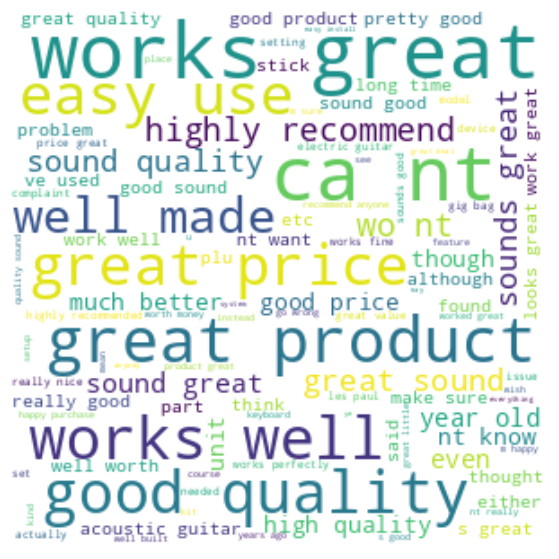

In [ ]:
text_pos = " ".join(i for i in pos)
# Create a word cloud image
wc_pos = WordCloud(width=300, height=300, max_words=100, background_color='white')
wc_pos.generate(text_pos)
plt.figure(figsize=(14,7))
plt.imshow(wc_pos, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Negative word cloud

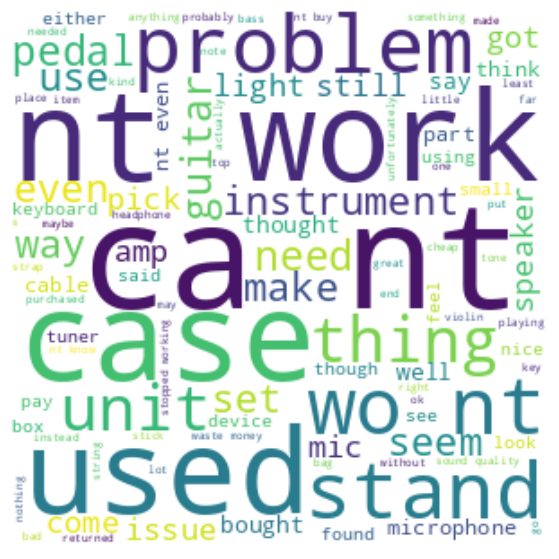

In [ ]:
text_neg = " ".join(i for i in neg)
# Create a word cloud image
wc_neg = WordCloud(width=300, height=300, max_words=100, background_color='white')
wc_neg.generate(text_neg)
plt.figure(figsize=(14,7))
plt.imshow(wc_neg, interpolation='bilinear')
plt.axis("off")
plt.show()

## Data undersampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

u1 = final_df['reviewText']
u2 = final_df['target']

undersample = RandomUnderSampler(sampling_strategy=1)

u1_resampled, u2_resampled = undersample.fit_resample(u1.values.reshape(-1, 1), u2)

df_resampled = pd.DataFrame({'reviewText': u1_resampled.flatten(), 'Target': u2_resampled})

# Check the balance of the target classes after undersampling
print(df_resampled['Target'].value_counts())

0    283151
1    283151
Name: Target, dtype: int64


# Preprocessing the Data - part 2

## Train test slpit

In [ ]:
df_overall1 = final_df['target'].value_counts()
df_overall1 = df_overall1.reset_index()
df_overall1.columns = ['senti', 'Count']
df_overall1

,senti,Count
0,1,1191760
1,0,283151


In [ ]:
plt.bar(df_overall1['senti'], df_overall1['Count'], color=['#1f77b4', '#ff7f0e'])

# Adding labels and title
plt.xlabel('pos/neg')
plt.ylabel('Count')
plt.title('Distribution of sentiment')

# Adding numbers on top of each bar
for i, value in enumerate(df_overall1['Count']):
    plt.annotate(str(value), (df_overall1['senti'][i], value), ha='center', va='bottom')

# Setting the y-axis tick interval as the values in the data are > 100000
plt.yticks(range(0, max(df_overall1['Count']), int(max(df_overall1['Count'])/7)))

# Displaying the graph
plt.show()

In [ ]:
df_resampled.head()

In [ ]:
df_overall2 = df_resampled['Target'].value_counts()
df_overall2 = df_overall2.reset_index()
df_overall2.columns = ['senti', 'Count']
df_overall2

In [ ]:
plt.bar(df_overall2['senti'], df_overall2['Count'], color=['#1f77b4', '#ff7f0e'])

# Adding labels and title
plt.xlabel('pos/neg')
plt.ylabel('Count')
plt.title('Distribution of sentiment')

# Adding numbers on top of each bar
for i, value in enumerate(df_overall2['Count']):
    plt.annotate(str(value), (df_overall2['senti'][i], value), ha='center', va='bottom')

# Setting the y-axis tick interval as the values in the data are > 100000
plt.yticks(range(0, max(df_overall2['Count']), int(max(df_overall2['Count'])/7)))

# Displaying the graph
plt.show()

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
#df_resampled = df_resampled[["reviewText", "Target"]][:50000]
#df_resampled.head(2)

In [ ]:
subset_data1 = df_resampled[df_resampled['Target']==1]
subset_data1 = subset_data1.head(25000)

In [ ]:
subset_data2 = df_resampled[df_resampled['Target']==0]
subset_data2 = subset_data2.head(25000)

In [ ]:
df_combined = pd.concat([subset_data1, subset_data2])

In [ ]:
x = df_combined['reviewText']
y = df_combined['Target']

X_train, X_test, y_train, y_test = train_test_split(x,y,random_state=100,train_size=0.8,shuffle=True)

In [ ]:
X_train.head()

305355                                            excelente
299610    beautiful  easy assemble  nt played years exci...
5593      case seemed get favorable reviews  ordered one...
15241     tune  c tunes c sharp sharp  may try tun pulli...
295146    gifts bought husband christmas  favorite  real...
Name: reviewText, dtype: object

## Tokenization

In [ ]:
# Tokenize the words

ENGLISH_STOP_WORDS = stopwords.words('english')

def tokenize(sentence):
   # to remove any space from beginning and the end of text
    listofwords = sentence.strip().split()
    listof_words = []
    for word in listofwords:
        if not word in ENGLISH_STOP_WORDS:
            lemm_word = WordNetLemmatizer().lemmatize(word)
            # remove the stop words
            if len(word)>0:
                listof_words.append(word)
    return(listof_words)

## Feature extraction

In [ ]:
#countvectorizer
from sklearn.feature_extraction.text import CountVectorizer

corpus = X_train

# initialize count vectorizer object

vect = CountVectorizer()

# get counts of each token (word) in text data

X = vect.fit_transform(corpus)

# convert sparse matrix to numpy array to view

X.toarray()

In [ ]:
print("vocabulary", vect.vocabulary_)

vocabulary {'perfect': 24285, 'affordable': 2991, 'easy': 11567, 'use': 35350, 'adaptable': 2762, 'good': 15027, 'alternative': 3312, 'expensive': 12805, 'power': 25257, 'cases': 6713, 'drives': 11140, 'stomp': 31647, 'boxes': 5774, 'fine': 13501, 'better': 5178, 'thn': 33274, 'batteries': 4860, 'case': 6706, 'seemed': 29150, 'get': 14765, 'favorable': 13213, 'reviews': 27831, 'ordered': 23312, 'one': 23097, 'amazon': 3364, 'order': 23310, 'took': 33767, 'road': 28104, 'big': 5235, 'deal': 9560, 'upon': 35267, 'unboxing': 34745, 'noticed': 22616, 'immediately': 17016, 'blemishes': 5399, 'like': 19334, 'looks': 19621, 'pretty': 25549, 'sturdy': 31989, 'soft': 30552, 'material': 20391, 'inside': 17477, 'protect': 25914, 'surfaces': 32326, 'guitar': 15473, 'hinges': 16330, 'hardware': 15828, 'seem': 29149, 'strong': 31889, 'enough': 12166, 'hold': 16440, 'long': 19580, 'haul': 15918, 'compartment': 7978, 'fit': 13599, 'box': 5772, 'extra': 12910, 'strings': 31858, 'string': 31847, 'winder

In [ ]:
print("shape", X.shape)

shape (40000, 37574)


In [ ]:
print("vectors:" , X.toarray())

vectors: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus1 = X_train

# initialize tf-idf vectorizer object
vectorizer = TfidfVectorizer()

# compute bag of word counts and tf-idf values
tf = vectorizer.fit_transform(corpus)

In [ ]:
# convert sparse matrix to numpy array to view
print("Vocabulary", vectorizer.vocabulary_)

Vocabulary {'perfect': 24285, 'affordable': 2991, 'easy': 11567, 'use': 35350, 'adaptable': 2762, 'good': 15027, 'alternative': 3312, 'expensive': 12805, 'power': 25257, 'cases': 6713, 'drives': 11140, 'stomp': 31647, 'boxes': 5774, 'fine': 13501, 'better': 5178, 'thn': 33274, 'batteries': 4860, 'case': 6706, 'seemed': 29150, 'get': 14765, 'favorable': 13213, 'reviews': 27831, 'ordered': 23312, 'one': 23097, 'amazon': 3364, 'order': 23310, 'took': 33767, 'road': 28104, 'big': 5235, 'deal': 9560, 'upon': 35267, 'unboxing': 34745, 'noticed': 22616, 'immediately': 17016, 'blemishes': 5399, 'like': 19334, 'looks': 19621, 'pretty': 25549, 'sturdy': 31989, 'soft': 30552, 'material': 20391, 'inside': 17477, 'protect': 25914, 'surfaces': 32326, 'guitar': 15473, 'hinges': 16330, 'hardware': 15828, 'seem': 29149, 'strong': 31889, 'enough': 12166, 'hold': 16440, 'long': 19580, 'haul': 15918, 'compartment': 7978, 'fit': 13599, 'box': 5772, 'extra': 12910, 'strings': 31858, 'string': 31847, 'winder

In [ ]:
print("idf", vectorizer.idf_)

idf [ 9.65074958  9.19876446 10.49804744 ...  9.98722182 10.21036537
 10.49804744]


In [ ]:
print("Vectors", tf.toarray())

Vectors [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
from gensim.models import Word2Vec

# Preprocess the text data
sentences = [sentence.split() for sentence in X_train]

# Train the Word2Vec model
model = Word2Vec(sentences, window=5, min_count=1, workers=4)

# Get word embeddings
word_embeddings = model.wv

In [ ]:
vocabulary = model.wv.key_to_index

In [ ]:
model.wv.most_similar('guitar')

[('guitars', 0.6859126091003418),
 ('banjo', 0.6739300489425659),
 ('taylor', 0.6532524824142456),
 ('uke', 0.6399092674255371),
 ('itch', 0.6294859647750854),
 ('mandolin', 0.6290290951728821),
 ('electric', 0.6283836364746094),
 ('acoustic', 0.620180070400238),
 ('violin', 0.6162717938423157),
 ('squier', 0.6110752820968628)]

In [ ]:
#similarity_score
model.wv.similarity('guitar', 'banjo')

0.6147241

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE()
tsne_e = tsne.fit_transform(vocabulary)

# Plot t-SNE result
plt.figure(figsize=(32, 32))
plt.scatter(tsne_e[:, 0], tsne_e[:, 1], marker='o', c=range(len(random_w)), cmap=plt.get_cmap('Spectral'))

for label, x, y, in zip(random_w, tsne_e[:, 0], tsne_e[:, 1]):
    plt.annotate(label,
                 xy=(x, y), xytext=(0, 15),
                 textcoords='offset points', ha='right', va='bottom',
                 bbox=dict(boxstyle='round, pad=0.2', fc='yellow', alpha=0.1))

## Vectorization

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec1 = TfidfVectorizer(min_df=100, tokenizer=tokenize, stop_words='english', ngram_range=(1,3)).fit(X_train)

X_train_vec = vec1.transform(X_train)
X_test_vec = vec1.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
X_train1

In [ ]:
#counting most repetitive words
word_counts = np.array(np.sum(X_train1, axis=0)).reshape((-1,))
words = np.array(vec1.get_feature_names_out())
words_df = pd.DataFrame({"word":words, "count":word_counts})
words_df.sort_values(by="count",ascending=False).head(20)

# Modeling

## SVM with Word2Vec

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_combined['reviewText'], df_combined['Target'], test_size=0.2, random_state=42)

# Tokenize the text data using simple_preprocess from gensim
def tokenize_text(text):
    return [token for token in simple_preprocess(text)]

# Apply tokenization to the training and testing data
X_train_tokens = [tokenize_text(text) for text in X_train]
X_test_tokens = [tokenize_text(text) for text in X_test]

# Train the Word2Vec model
model_w2v = Word2Vec(sentences=X_train_tokens, vector_size=100, window=5, min_count=1)

# Function to compute the average word vectors for a sentence
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    n_words = 0
    for word in words:
        if word in vocabulary:
            n_words += 1
            feature_vector = np.add(feature_vector, model.wv[word])
    if n_words > 0:
        feature_vector = np.divide(feature_vector, n_words)
    return feature_vector




In [ ]:
# Create feature vectors using the Word2Vec model
train_vectors = [average_word_vectors(tokens, model_w2v, model_w2v.wv.key_to_index, 100) for tokens in X_train_tokens]
test_vectors = [average_word_vectors(tokens, model_w2v, model_w2v.wv.key_to_index, 100) for tokens in X_test_tokens]

# Initialize and train the SVM classifier
svm1 = SVC(kernel='linear')
svm1.fit(train_vectors, y_train)

# Make predictions on the test set
y_pred = svm1.predict(test_vectors)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8055


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)

# Calculate confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

In [ ]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8055
Precision: 0.8368732209327786
Recall: 0.7610513739545998
F1 Score: 0.7971634164146417


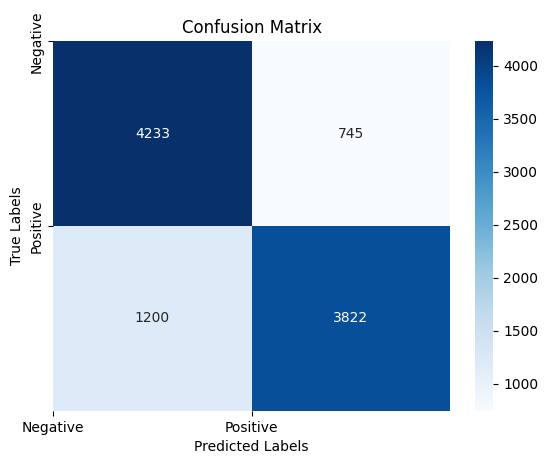

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
sns.heatmap(confusion_mat, annot=True, cmap='Blues', fmt='d')

# Add labels, title, and axis ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.yticks([0, 1], ['Negative', 'Positive'])

# Display the plot
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

# Calculate AUC-ROC score
auc_roc = roc_auc_score(y_test, y_pred)
auc_roc

0.8056964382830453

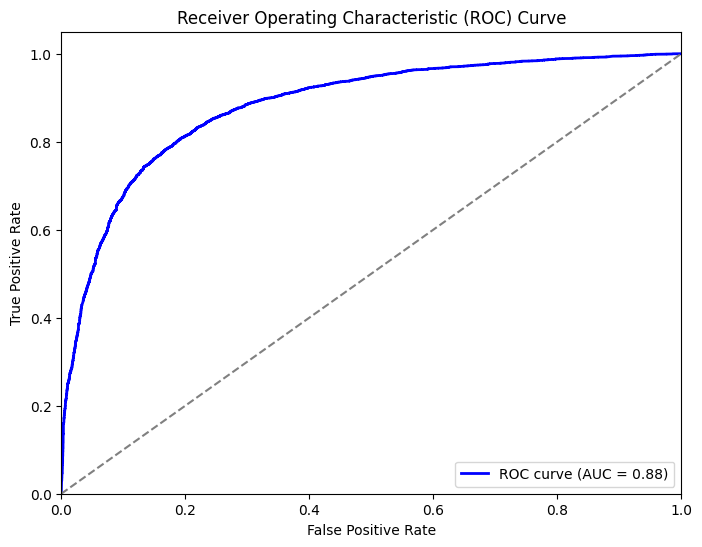

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate decision values for ROC curve and AUC-ROC score
decision_values = svm1.decision_function(test_vectors)

# Calculate the AUC-ROC score
auc_roc = roc_auc_score(y_test, decision_values)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, decision_values)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_roc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
import pickle

# Save the SVM model to a file
with open('svm_model.pkl', 'wb') as file:
    pickle.dump(svm1, file)

In [ ]:
df_combined.head(1)

## SVM with TF IDF

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Split the data into training and testing sets
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(df_combined['reviewText'], df_combined['Target'], test_size=0.2, random_state=42)

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train_vectorized = vectorizer.fit_transform(X_train_tf)

# Transform the testing data
X_test_vectorized = vectorizer.transform(X_test_tf)


In [ ]:
# Initialize and train the SVM classifier
svm = SVC(kernel='linear')
svm.fit(X_train_vectorized, y_train_tf)

# Make predictions on the test set
y_pred_tf = svm.predict(X_test_vectorized)

# Evaluate the model
accuracy_tf = accuracy_score(y_test_tf, y_pred_tf)
print("Accuracy:", accuracy_tf)

Accuracy: 0.8525


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Calculate precision
precision_tf = precision_score(y_test_tf, y_pred_tf)

# Calculate recall
recall_tf = recall_score(y_test_tf, y_pred_tf)

# Calculate F1 score
f1_tf = f1_score(y_test_tf, y_pred_tf)

# Calculate confusion matrix
confusion_mat_tf = confusion_matrix(y_test_tf, y_pred_tf)

In [ ]:
# Save the SVM model to a file
with open('svm_model_wv.pkl', 'wb') as file:
    pickle.dump(svm, file)

In [ ]:
print("Accuracy:", accuracy_tf)
print("Precision:", precision_tf)
print("Recall:", recall_tf)
print("F1 Score:", f1_tf)

Accuracy: 0.8525
Precision: 0.8585001010713563
Recall: 0.845679012345679
F1 Score: 0.8520413281171633


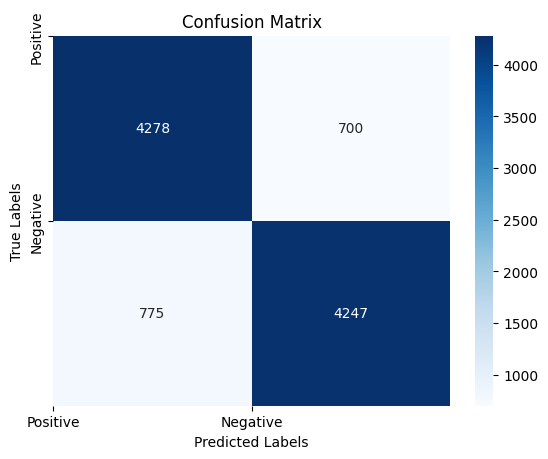

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
confusion_mat = confusion_matrix(y_test_tf, y_pred_tf)

# Create a heatmap of the confusion matrix
sns.heatmap(confusion_mat, annot=True, cmap='Blues', fmt='d')

# Add labels, title, and axis ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks([0, 1], ['Positive', 'Negative'])
plt.yticks([0, 1], ['Positive', 'Negative'])

# Display the plot
plt.show()

In [ ]:
# Calculate precision
precision_tf = precision_score(y_test_tf, y_pred_tf)

# Calculate recall
recall_tf = recall_score(y_test_tf, y_pred_tf)

# Calculate F1 score
f1_tf = f1_score(y_test_tf, y_pred_tf)

# Calculate confusion matrix
confusion_mat_tf = confusion_matrix(y_test_tf, y_pred_tf)

# Calculate AUC-ROC score
y_pred_prob_tf = svm.decision_function(X_test_vectorized)
roc_auc_tf = roc_auc_score(y_test_tf, y_pred_prob_tf)
print("AUC-ROC Score:", roc_auc_tf)

AUC-ROC Score: 0.9253334344552911


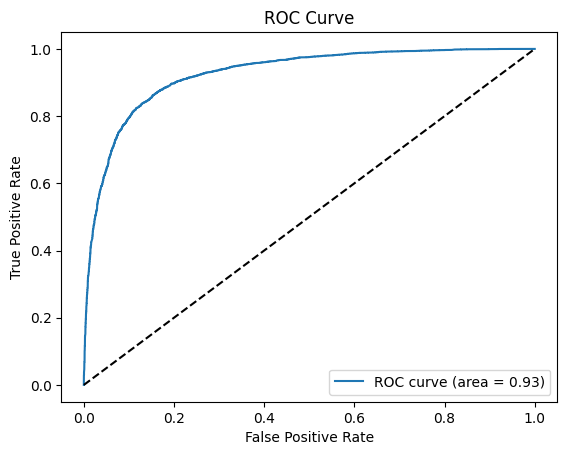

In [ ]:
# Plot the ROC curve
fpr_tf, tpr_tf, thresholds_tf = roc_curve(y_test_tf, y_pred_prob_tf)
plt.plot(fpr_tf, tpr_tf, label='ROC curve (area = %0.2f)' % roc_auc_tf)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## LSTM with Word2Vec

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
# Train Word2Vec model
from gensim.models import Word2Vec

sentences = [text.split() for text in df_combined['reviewText']]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1)

In [ ]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_combined['reviewText'])
sequences = tokenizer.texts_to_sequences(df_combined['reviewText'])

In [ ]:
# Pad sequences
max_len = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_len)

In [ ]:
# Split the data into training and testing sets
X = padded_sequences
y = df_combined['Target']
X_train_lv, X_test_lv, y_train_lv, y_test_lv = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Build LSTM model
#vocab_size = len(tokenizer.word_index) + 1
#embedding_matrix = word2vec_model.wv.vectors
#embedding_dim = word2vec_model.vector_size

#model = Sequential()
#model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False))
#model.add(LSTM(100))
#model.add(Dense(1, activation='sigmoid'))

#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# Prepare the word embedding matrix
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = word2vec_model.vector_size

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

# Build LSTM model
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Assuming you have your data 'X' and 'y', and then train the model
model.fit(X, y, batch_size=32, epochs=5, validation_split=0.2)

Epoch 1/5
1250/1250 [==============================] - 62s 46ms/step - loss: 0.4293 - accuracy: 0.7995 - val_loss: 0.4699 - val_accuracy: 0.8002
Epoch 2/5
1250/1250 [==============================] - 56s 45ms/step - loss: 0.3697 - accuracy: 0.8349 - val_loss: 0.4433 - val_accuracy: 0.8007
Epoch 3/5
1250/1250 [==============================] - 55s 44ms/step - loss: 0.3390 - accuracy: 0.8493 - val_loss: 0.4814 - val_accuracy: 0.7681
Epoch 4/5
1250/1250 [==============================] - 55s 44ms/step - loss: 0.3147 - accuracy: 0.8631 - val_loss: 0.5011 - val_accuracy: 0.7662
Epoch 5/5
1250/1250 [==============================] - 55s 44ms/step - loss: 0.2901 - accuracy: 0.8758 - val_loss: 0.7465 - val_accuracy: 0.6487


In [ ]:

# Train the LSTM model
model.fit(X_train_lv, y_train_lv, validation_data=(X_test_lv, y_test_lv), epochs=10)

Epoch 1/10
1250/1250 [==============================] - 55s 44ms/step - loss: 0.3030 - accuracy: 0.8686 - val_loss: 0.3141 - val_accuracy: 0.8671
Epoch 2/10
1250/1250 [==============================] - 55s 44ms/step - loss: 0.2742 - accuracy: 0.8833 - val_loss: 0.3207 - val_accuracy: 0.8647
Epoch 3/10
1250/1250 [==============================] - 56s 44ms/step - loss: 0.3114 - accuracy: 0.8644 - val_loss: 0.3605 - val_accuracy: 0.8465
Epoch 4/10
1250/1250 [==============================] - 55s 44ms/step - loss: 0.2553 - accuracy: 0.8939 - val_loss: 0.3372 - val_accuracy: 0.8593
Epoch 5/10
1250/1250 [==============================] - 55s 44ms/step - loss: 0.2288 - accuracy: 0.9055 - val_loss: 0.3405 - val_accuracy: 0.8581
Epoch 6/10
1250/1250 [==============================] - 55s 44ms/step - loss: 0.2063 - accuracy: 0.9161 - val_loss: 0.3555 - val_accuracy: 0.8550
Epoch 7/10
1250/1250 [==============================] - 55s 44ms/step - loss: 0.1847 - accuracy: 0.9262 - val_loss: 0.3809 -

In [ ]:
# Generate predictions
y_pred_prob_lv = model.predict(X_test_lv)
y_pred_lv = (y_pred_prob_lv > 0.5).astype(int)

313/313 [==============================] - 5s 15ms/step


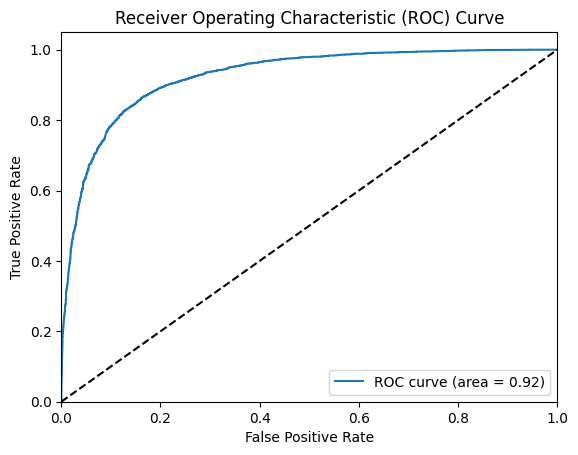

Accuracy: 0.8492
Precision: 0.8588643790849673
Recall: 0.83731581043409
F1 Score: 0.8479532163742689
Confusion Matrix:
[[4287  691]
 [ 817 4205]]


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Assuming you already have the predictions 'y_pred_lv' and the ground truth 'y_test_lv'

# Calculate Accuracy
accuracy = accuracy_score(y_test_lv, y_pred_lv)

# Calculate Precision
precision = precision_score(y_test_lv, y_pred_lv)

# Calculate Recall
recall = recall_score(y_test_lv, y_pred_lv)

# Calculate F1 Score
f1 = f1_score(y_test_lv, y_pred_lv)

# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_test_lv, y_pred_lv)

# Calculate AUC ROC
y_pred_prob_lv = y_pred_prob_lv.ravel()  # Flatten y_pred_prob_lv if needed
auc_roc = roc_auc_score(y_test_lv, y_pred_prob_lv)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test_lv, y_pred_prob_lv)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Print the Confusion Matrix
print("Confusion Matrix:")
print(conf_matrix)

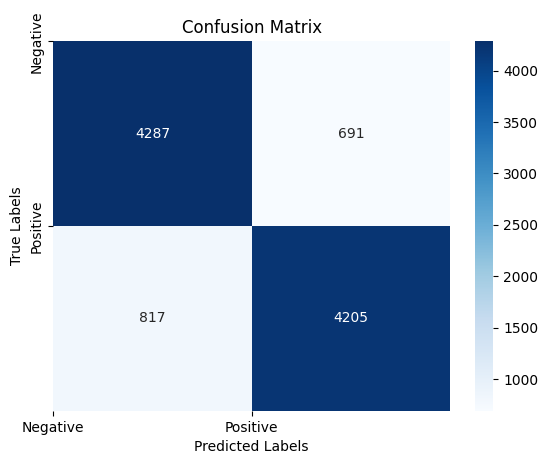

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
confusion_mat = confusion_matrix(y_test_lv, y_pred_lv)

# Create a heatmap of the confusion matrix
sns.heatmap(confusion_mat, annot=True, cmap='Blues', fmt='d')

# Add labels, title, and axis ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.yticks([0, 1], ['Negative', 'Positive'])

# Display the plot
plt.show()

## LSTM with TF IDF

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Convert any non-string values to strings
df_combined['reviewText'] = df_combined['reviewText'].astype(str)

# Preprocess the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_combined['reviewText'])
sequences = tokenizer.texts_to_sequences(df_combined['reviewText'])
word_index = tokenizer.word_index
max_sequence_length = max([len(seq) for seq in sequences])
X = pad_sequences(sequences, maxlen=max_sequence_length)

# Prepare the target variable
y = df_combined['Target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Build the LSTM model
model = Sequential()
model.add(Embedding(len(word_index) + 1, 100, input_length=max_sequence_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compile and train the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

Epoch 1/10
1250/1250 [==============================] - 145s 114ms/step - loss: 0.4005 - accuracy: 0.8224 - val_loss: 0.3759 - val_accuracy: 0.8464
Epoch 2/10
1250/1250 [==============================] - 72s 58ms/step - loss: 0.2757 - accuracy: 0.8859 - val_loss: 0.3900 - val_accuracy: 0.8465
Epoch 3/10
1250/1250 [==============================] - 67s 54ms/step - loss: 0.2090 - accuracy: 0.9159 - val_loss: 0.4146 - val_accuracy: 0.8409
Epoch 4/10
1250/1250 [==============================] - 64s 51ms/step - loss: 0.1616 - accuracy: 0.9370 - val_loss: 0.4770 - val_accuracy: 0.8392
Epoch 5/10
1250/1250 [==============================] - 63s 50ms/step - loss: 0.1316 - accuracy: 0.9495 - val_loss: 0.5741 - val_accuracy: 0.8345
Epoch 6/10
1250/1250 [==============================] - 62s 49ms/step - loss: 0.1119 - accuracy: 0.9582 - val_loss: 0.5708 - val_accuracy: 0.8248
Epoch 7/10
1250/1250 [==============================] - 61s 48ms/step - loss: 0.0947 - accuracy: 0.9651 - val_loss: 0.6846

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)


# input_text_all = []
# predicted_output_all = []
# # Show input and predicted output for each sample
# for i in range(5):
#     input_text = tokenizer.sequences_to_texts([X_test[i]])[0]
#     predicted_output = model.predict_classes(X_test[i].reshape(1, -1))[0][0]
#     print("Input:", input_text)
#     print("Predicted Output:", predicted_output)
#     input_text_all.append(input_text)
#     predicted_output_all.append(predicted_output)
#     print("-----------")


313/313 [==============================] - 5s 17ms/step - loss: 0.8920 - accuracy: 0.8239
Loss: 0.8919852375984192
Accuracy: 0.8238999843597412


In [ ]:
# Generate predictions
y_pred = model.predict(X_test)

# Convert predictions to labels
y_pred_labels = ['positive' if pred == 1 else 'negative' for pred in y_pred]


313/313 [==============================] - 6s 18ms/step


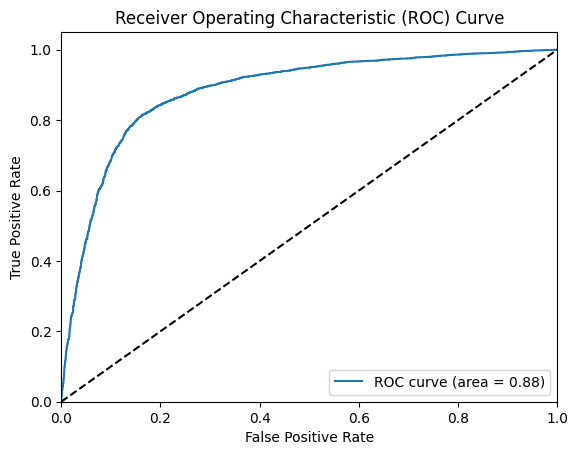

Precision: 0.8414659685863874
Recall: 0.8000796495420152
F1 Score: 0.820251097274676
AUC ROC Score: 0.8834626438367847
Confusion Matrix:
[[4221  757]
 [1004 4018]]


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt

# Assuming you have already defined 'y_test' and 'y_pred'

# Convert probabilities to labels (assuming binary classification)
y_pred_labels = np.round(y_pred).astype(int)
y_test_labels = y_test.astype(int)

# Calculate Precision
precision = precision_score(y_test_labels, y_pred_labels)

# Calculate Recall
recall = recall_score(y_test_labels, y_pred_labels)

# Calculate F1 Score
f1 = f1_score(y_test_labels, y_pred_labels)

# Calculate AUC ROC Score
roc_auc = roc_auc_score(y_test_labels, y_pred)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test_labels, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)

# Print the evaluation metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC ROC Score:", roc_auc)

# Print the Confusion Matrix
print("Confusion Matrix:")
print(conf_matrix)

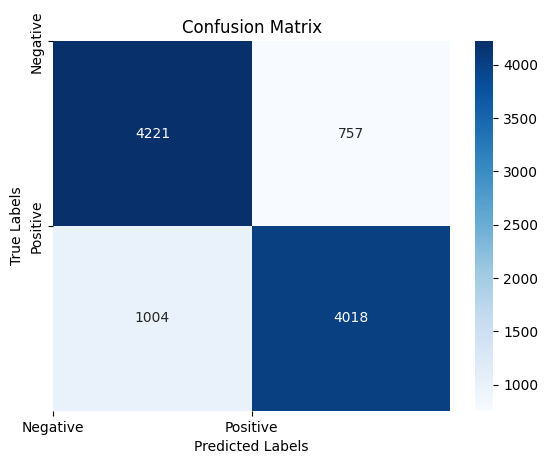

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
confusion_mat = confusion_matrix(y_test_labels, y_pred_labels)

# Create a heatmap of the confusion matrix
sns.heatmap(confusion_mat, annot=True, cmap='Blues', fmt='d')

# Add labels, title, and axis ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.yticks([0, 1], ['Negative', 'Positive'])

# Display the plot
plt.show()

## CNN with TF IDF

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_combined['reviewText'], df_combined['Target'], test_size=0.2, random_state=42)

# Encode the target labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Initialize and fit the TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()

# Reshape the input data for compatibility with CNN
X_train_tfidf = np.expand_dims(X_train_tfidf, axis=2)
X_test_tfidf = np.expand_dims(X_test_tfidf, axis=2)

In [ ]:
# Build the CNN model
model = Sequential()
model.add(Conv1D(128, 5, activation='relu', input_shape=(X_train_tfidf.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Train the model
model.fit(X_train_tfidf, y_train, batch_size=64, epochs=2, validation_data=(X_test_tfidf, y_test))

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_tfidf, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)

In [ ]:
# Make predictions on the test set
y_pred_prob = model.predict(X_test_tfidf)
y_pred_classes = (y_pred_prob > 0.5).astype(int)

# Get the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred_classes)

# Create a heatmap of the confusion matrix
sns.heatmap(confusion_mat, annot=True, cmap='Blues', fmt='d')

# Add labels, title, and axis ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.yticks([0, 1], ['Negative', 'Positive'])

# Display the plot
plt.show()


Epoch 1/10
625/625 [==============================] - 128s 187ms/step - loss: 0.6836 - accuracy: 0.5519 - val_loss: 0.6792 - val_accuracy: 0.5675
Epoch 2/10
625/625 [==============================] - 114s 183ms/step - loss: 0.6807 - accuracy: 0.5619 - val_loss: 0.6793 - val_accuracy: 0.5679
Epoch 3/10
625/625 [==============================] - 115s 184ms/step - loss: 0.6805 - accuracy: 0.5658 - val_loss: 0.6794 - val_accuracy: 0.5642
Epoch 4/10
625/625 [==============================] - 115s 184ms/step - loss: 0.6803 - accuracy: 0.5644 - val_loss: 0.6802 - val_accuracy: 0.5677
Epoch 5/10
625/625 [==============================] - 115s 184ms/step - loss: 0.6801 - accuracy: 0.5654 - val_loss: 0.6794 - val_accuracy: 0.5677
Epoch 6/10
625/625 [==============================] - 115s 184ms/step - loss: 0.6806 - accuracy: 0.5641 - val_loss: 0.6804 - val_accuracy: 0.5624
Epoch 7/10
625/625 [==============================] - 115s 184ms/step - loss: 0.6804 - accuracy: 0.5640 - val_loss: 0.6791 -

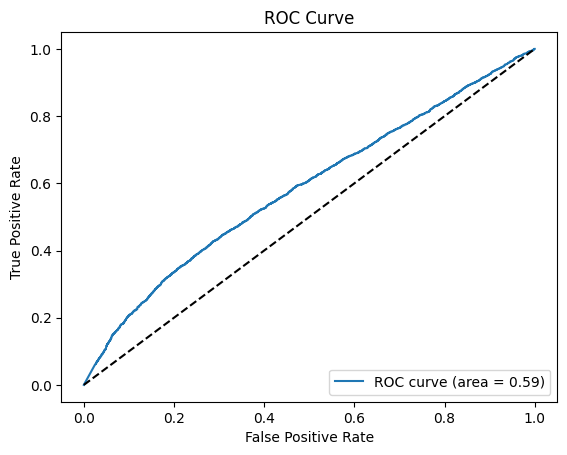

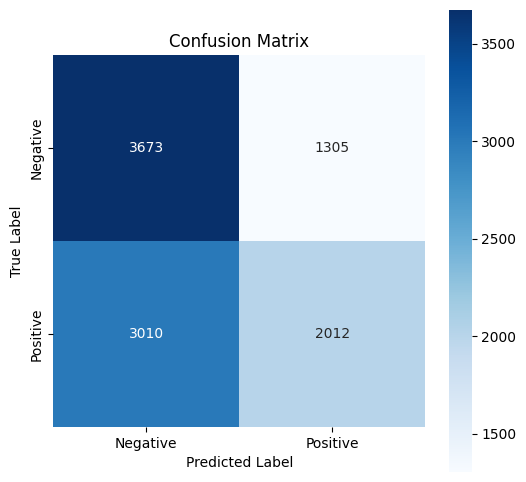

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_combined['reviewText'], df_combined['Target'], test_size=0.2, random_state=42)

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Build the CNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dense, Dropout

model = Sequential()
model.add(Conv1D(128, 5, activation='relu', input_shape=(X_train_tfidf.shape[1], 1)))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train_tfidf.toarray().reshape(X_train_tfidf.shape[0], X_train_tfidf.shape[1], 1), y_train, batch_size=64, epochs=10, validation_data=(X_test_tfidf.toarray().reshape(X_test_tfidf.shape[0], X_test_tfidf.shape[1], 1), y_test))

# Make predictions on the test set
y_pred_prob = model.predict(X_test_tfidf.toarray().reshape(X_test_tfidf.shape[0], X_test_tfidf.shape[1], 1))
y_pred_classes = (y_pred_prob > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_classes)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_test, y_pred_classes)

# Calculate recall
recall = recall_score(y_test, y_pred_classes)

# Calculate F1 score
f1 = f1_score(y_test, y_pred_classes)

# Calculate AUC-ROC score
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the colored confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True, xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Epoch 1/10
625/625 [==============================] - 126s 185ms/step - loss: 0.6839 - accuracy: 0.5521 - val_loss: 0.6776 - val_accuracy: 0.5683
Epoch 2/10
625/625 [==============================] - 113s 180ms/step - loss: 0.6809 - accuracy: 0.5655 - val_loss: 0.6778 - val_accuracy: 0.5717
Epoch 3/10
625/625 [==============================] - 112s 180ms/step - loss: 0.6809 - accuracy: 0.5676 - val_loss: 0.6778 - val_accuracy: 0.5705
Epoch 4/10
625/625 [==============================] - 112s 180ms/step - loss: 0.6810 - accuracy: 0.5642 - val_loss: 0.6778 - val_accuracy: 0.5710
Epoch 5/10
625/625 [==============================] - 112s 180ms/step - loss: 0.6812 - accuracy: 0.5658 - val_loss: 0.6795 - val_accuracy: 0.5710
Epoch 6/10
625/625 [==============================] - 112s 180ms/step - loss: 0.6808 - accuracy: 0.5655 - val_loss: 0.6785 - val_accuracy: 0.5706
Epoch 7/10
625/625 [==============================] - 113s 180ms/step - loss: 0.6812 - accuracy: 0.5653 - val_loss: 0.6778 -

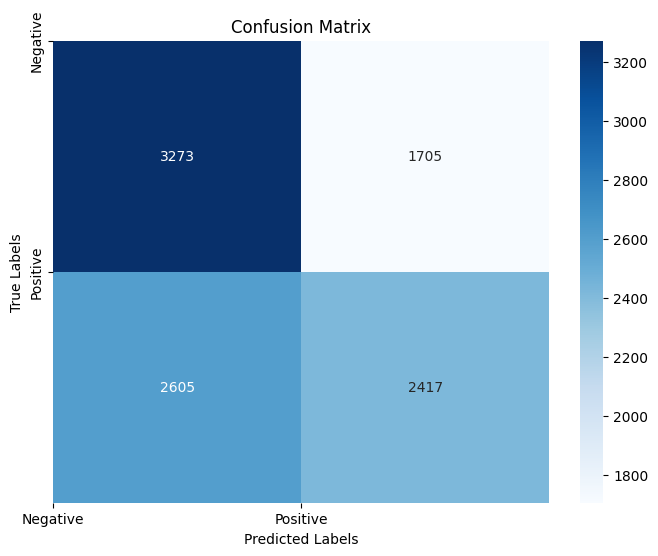

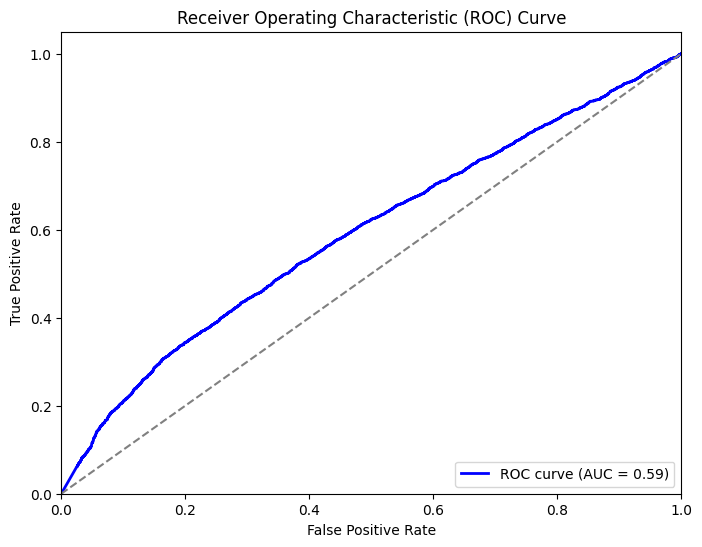

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a DataFrame named df_combined with columns 'reviewText' and 'Target'

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_combined['reviewText'], df_combined['Target'], test_size=0.2, random_state=42)

# Initialize and fit the TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()

# Reshape the input data for compatibility with CNN
X_train_tfidf = np.expand_dims(X_train_tfidf, axis=2)
X_test_tfidf = np.expand_dims(X_test_tfidf, axis=2)

# Build the CNN model
model = Sequential()
model.add(Conv1D(128, 5, activation='relu', input_shape=(X_train_tfidf.shape[1], 1)))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train_tfidf, y_train, batch_size=64, epochs=10, validation_data=(X_test_tfidf, y_test))

# Make predictions on the test set
y_pred_probs = model.predict(X_test_tfidf)
y_pred_classes = (y_pred_probs > 0.5).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
roc_auc = roc_auc_score(y_test, y_pred_probs)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC-ROC Score:", roc_auc)

# Calculate confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.yticks([0, 1], ['Negative', 'Positive'])
plt.show()

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# Calculate confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.yticks([0, 1], ['Negative', 'Positive'])
plt.show()

## CNN Word2Vec

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_combined['reviewText'], df_combined['Target'], test_size=0.2, random_state=42)

In [ ]:
# Encode the target labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Tokenize the text data and train Word2Vec model
tokenized_text = [text.split() for text in X_train]
word2vec_model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1)

# Convert text data to sequences of word indices
X_train_seq = []
for text in X_train:
    seq = [word2vec_model.wv.key_to_index[word] for word in text.split() if word in word2vec_model.wv]
    X_train_seq.append(seq)

X_test_seq = []
for text in X_test:
    seq = [word2vec_model.wv.key_to_index[word] for word in text.split() if word in word2vec_model.wv]
    X_test_seq.append(seq)

# Pad sequences to have the same length
max_seq_length = max([len(seq) for seq in X_train_seq + X_test_seq])
X_train_padded = pad_sequences(X_train_seq, maxlen=max_seq_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_seq_length)

# Create the embedding matrix from the Word2Vec model
vocab_size = len(word2vec_model.wv)
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word2vec_model.wv.key_to_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

# Build the CNN model
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_seq_length, trainable=False))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train_padded, y_train, batch_size=64, epochs=10, validation_data=(X_test_padded, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)

Epoch 1/10
625/625 [==============================] - 24s 21ms/step - loss: 0.4829 - accuracy: 0.7703 - val_loss: 0.4336 - val_accuracy: 0.7988
Epoch 2/10
625/625 [==============================] - 14s 23ms/step - loss: 0.4336 - accuracy: 0.8033 - val_loss: 0.4097 - val_accuracy: 0.8141
Epoch 3/10
625/625 [==============================] - 14s 23ms/step - loss: 0.4053 - accuracy: 0.8193 - val_loss: 0.4139 - val_accuracy: 0.8072
Epoch 4/10
625/625 [==============================] - 14s 23ms/step - loss: 0.3811 - accuracy: 0.8317 - val_loss: 0.3951 - val_accuracy: 0.8226
Epoch 5/10
625/625 [==============================] - 15s 23ms/step - loss: 0.3612 - accuracy: 0.8415 - val_loss: 0.4011 - val_accuracy: 0.8216
Epoch 6/10
625/625 [==============================] - 14s 22ms/step - loss: 0.3375 - accuracy: 0.8548 - val_loss: 0.4111 - val_accuracy: 0.8213
Epoch 7/10
625/625 [==============================] - 14s 22ms/step - loss: 0.3153 - accuracy: 0.8633 - val_loss: 0.4353 - val_accuracy:

In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test_padded)
y_pred_classes = (y_pred > 0.5).astype(int)

313/313 [==============================] - 2s 5ms/step


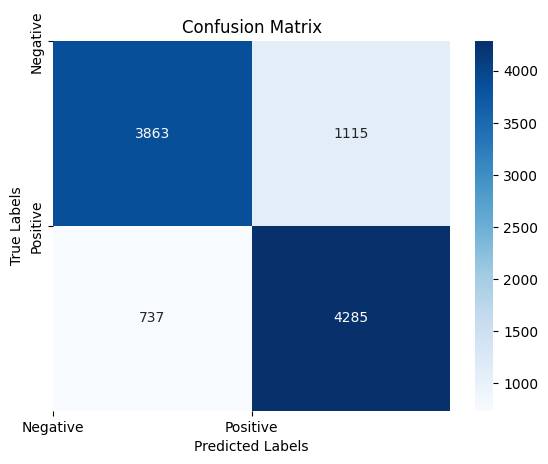

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred_classes)

# Create a heatmap of the confusion matrix
sns.heatmap(confusion_mat, annot=True, cmap='Blues', fmt='d')

# Add labels, title, and axis ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.yticks([0, 1], ['Negative', 'Positive'])

# Display the plot
plt.show()

AUC ROC Score: 0.8950023072446682


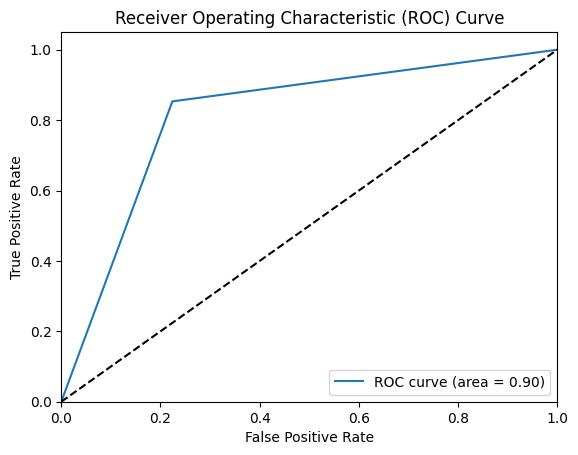

Accuracy: 0.8148
Precision: 0.7935185185185185
Recall: 0.8532457188371166
F1 Score: 0.8222989829207444


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Assuming you already have the predictions 'y_pred_lv' and the ground truth 'y_test_lv'

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_classes)

# Calculate Precision
precision = precision_score(y_test, y_pred_classes)

# Calculate Recall
recall = recall_score(y_test, y_pred_classes)

# Calculate F1 Score
f1 = f1_score(y_test, y_pred_classes)

# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Calculate AUC ROC
auc_roc = roc_auc_score(y_test, y_pred)
print("AUC ROC Score:", auc_roc)


# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_classes)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Convert probabilities to binary predictions
y_pred_classes = (y_pred > 0.5).astype(int)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.7935185185185185
Recall: 0.8532457188371166
F1-score: 0.8222989829207444


In [ ]:
# Calculate the AUC-ROC score
roc_auc = roc_auc_score(y_test, y_pred)
print("AUC-ROC Score:", roc_auc)

In [ ]:
# Plot the ROC curve
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## BERT

In [ ]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118!

In [ ]:
!pip install transformers

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW


# Split the dataset into train and test sets
train_df = df_combined.sample(frac=0.8, random_state=42)
test_df = df_combined.drop(train_df.index)

# Define a custom dataset class for BERT input
class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = str(self.texts[index])
        label = self.labels[index]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

def tokenize(texts, tokenizer):
    # Tokenize a list of texts using the given tokenizer
    return tokenizer.batch_encode_plus(
        texts,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )


# Set the device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

# Define the optimizer and learning rate
optimizer = AdamW(model.parameters(), lr=2e-5)

# Set the batch size and maximum sequence length
batch_size = 16
max_length = 150

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Create the train and test datasets and dataloaders
train_dataset = ReviewDataset(train_df['reviewText'].tolist(), train_df['Target'].tolist(), tokenizer, max_length)
test_dataset = ReviewDataset(test_df['reviewText'].tolist(), test_df['Target'].tolist(), tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Training loop
model.train()
# List to store training summary
training_summary = []

for epoch in range(5):  # Number of training epochs
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.logits, dim=1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    average_loss = total_loss / len(train_dataloader)
    accuracy = total_correct / total_samples
    print(f'Epoch {epoch + 1}/{10}, Loss: {average_loss}')

    # Save training summary for this epoch
    training_summary.append({'epoch': epoch + 1, 'loss': average_loss, 'accuracy': accuracy})

Epoch 1/10, Loss: 0.363907938195765
Epoch 2/10, Loss: 0.25286221598535774
Epoch 3/10, Loss: 0.1582218209605664
Epoch 4/10, Loss: 0.09957233826331795
Epoch 5/10, Loss: 0.07235494774971157


In [ ]:
for epoch_summary in training_summary:
    print(f"Epoch {epoch_summary['epoch']}, Loss: {epoch_summary['loss']}, Accuracy: {epoch_summary['accuracy']}")

Epoch 1, Loss: 0.363907938195765, Accuracy: 0.8405
Epoch 2, Loss: 0.25286221598535774, Accuracy: 0.898925
Epoch 3, Loss: 0.1582218209605664, Accuracy: 0.939175
Epoch 4, Loss: 0.09957233826331795, Accuracy: 0.9645
Epoch 5, Loss: 0.07235494774971157, Accuracy: 0.974475


In [ ]:
# Evaluation loop
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(outputs.logits, dim=1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy}')

Test Accuracy: 0.8627


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Evaluation loop
model.eval()
with torch.no_grad():
    y_true = []
    y_pred = []
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(outputs.logits, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

    accuracy = np.mean(np.array(y_true) == np.array(y_pred))
    print(f'Test Accuracy: {accuracy}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
target_names = ['Class 0', 'Class 1']
classification_rep = classification_report(y_true, y_pred, target_names=target_names)
print("Classification Report:")
print(classification_rep)

Test Accuracy: 0.8627
Confusion Matrix:
[[4040  885]
 [ 488 4587]]
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.89      0.82      0.85      4925
     Class 1       0.84      0.90      0.87      5075

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



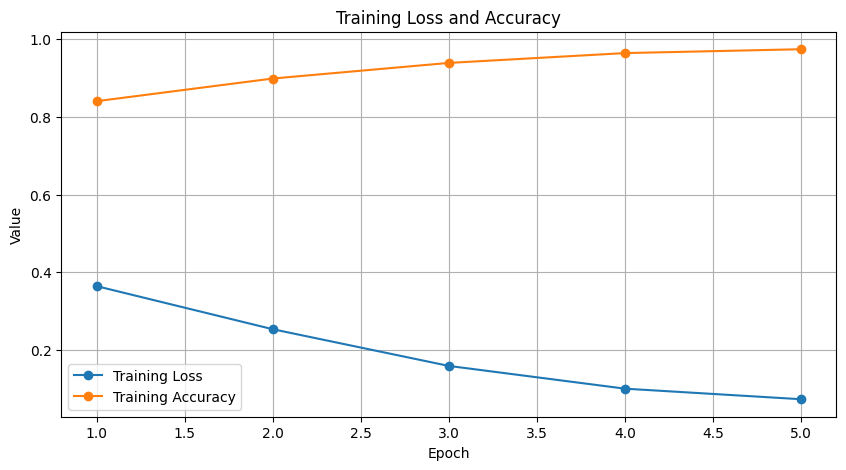

In [ ]:
# Plot accuracy and loss
epochs = [epoch_summary['epoch'] for epoch_summary in training_summary]
losses = [epoch_summary['loss'] for epoch_summary in training_summary]
accuracies = [epoch_summary['accuracy'] for epoch_summary in training_summary]

plt.figure(figsize=(10, 5))
plt.plot(epochs, losses, label='Training Loss', marker='o')
plt.plot(epochs, accuracies, label='Training Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Loss and Accuracy')
plt.legend()
plt.grid()
plt.show()

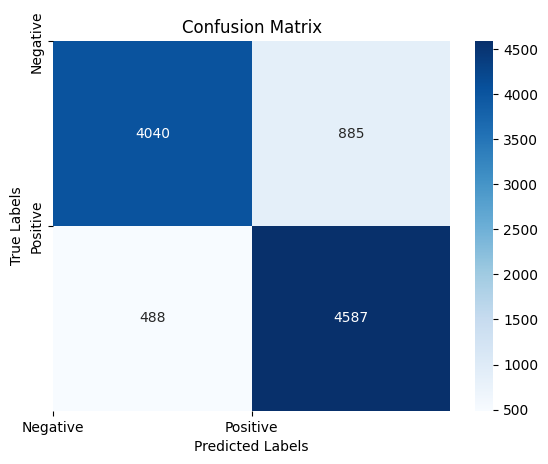

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)

# Create a heatmap of the confusion matrix
sns.heatmap(confusion_mat, annot=True, cmap='Blues', fmt='d')

# Add labels, title, and axis ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.yticks([0, 1], ['Negative', 'Positive'])

# Display the plot
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

# Calculate AUC-ROC score
auc_roc = roc_auc_score(y_true, y_pred)
auc_roc

0.8620734665299692

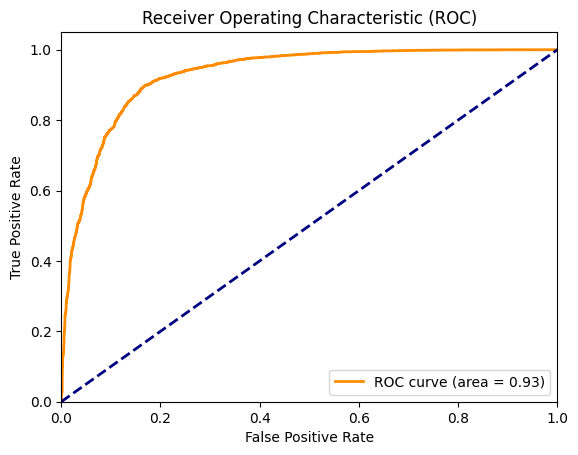

Test Accuracy: 0.8627
Precision: 0.8382675438596491
Recall: 0.9038423645320197
F1 Score: 0.8698208021238267
AUC ROC Score: 0.9287978395138906
Confusion Matrix:
[[4040  885]
 [ 488 4587]]


In [ ]:
import torch
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

# ... (previous code for data preprocessing and loading the model)

# Evaluation loop
model.eval()
predictions = []
true_labels = []
probs = []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        true_labels.extend(labels.cpu().numpy())

        outputs = model(input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(outputs.logits, dim=1)
        predictions.extend(predicted.cpu().numpy())

        # Get probabilities for the positive class (class 1)
        probs.extend(torch.softmax(outputs.logits, dim=1)[:, 1].cpu().numpy())

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
roc_auc = roc_auc_score(true_labels, probs)
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot ROC curve
fpr, tpr, _ = roc_curve(true_labels, probs)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Print evaluation metrics
print(f'Test Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'AUC ROC Score: {roc_auc}')
print('Confusion Matrix:')
print(conf_matrix)


## Comparing the models

In [ ]:
# Sample performance metrics (replace these with actual values from your results)
svm_tfidf_accuracy = 85.3
svm_bayes_tfidf_precision = 85.7
svm_bayes_tfidf_recall = 84.8
svm_bayes_tfidf_f1 = 85.2

svm_word2vec_accuracy = 80.4
svm_word2vec_precision = 83.7
svm_word2vec_recall = 76.3
svm_word2vec_f1 = 79.9

lstm_tfidf_accuracy = 82.3
lstm_tfidf_precision = 84.1
lstm_tfidf_recall = 80
lstm_tfidf_f1 = 82

lstm_word2vec_accuracy = 84.9
lstm_word2vec_precision = 85.8
lstm_word2vec_recall = 83.7
lstm_word2vec_f1 = 84.7

cnn_tfidf_accuracy = 57.8
cnn_tfidf_precision = 60.6
cnn_tfidf_recall = 48.1
cnn_tfidf_f1 = 40

cnn_word2vec_accuracy = 81
cnn_word2vec_precision = 79.9
cnn_word2vec_recall = 85
cnn_word2vec_f1 = 82.3

bert_accuracy = 86.3
bert_precision = 83.8
bert_recall = 90.3
bert_f1 = 86.9


In [ ]:
# Performance metrics for each algorithm
algorithms = ['SVM (Word2Vec)', 'SVM (TF-IDF)', 'LSTM (Word2Vec)' ,'LSTM (TF-IDF)', 'CNN (Word2Vec)', 'CNN (TF-IDF)', 'BERT']
accuracy = [svm_word2vec_accuracy, svm_tfidf_accuracy,lstm_word2vec_accuracy, lstm_tfidf_accuracy,cnn_word2vec_accuracy,cnn_tfidf_accuracy, bert_accuracy]
precision = [svm_word2vec_precision, svm_bayes_tfidf_precision, lstm_word2vec_precision,lstm_tfidf_precision,cnn_word2vec_precision,cnn_tfidf_precision, bert_precision]
recall = [svm_word2vec_recall, svm_bayes_tfidf_recall,lstm_word2vec_recall, lstm_tfidf_recall, cnn_word2vec_recall, cnn_tfidf_recall, bert_recall]
f1 = [svm_word2vec_f1, svm_bayes_tfidf_f1, lstm_word2vec_f1, lstm_tfidf_f1, cnn_word2vec_f1, cnn_tfidf_f1,  bert_f1]

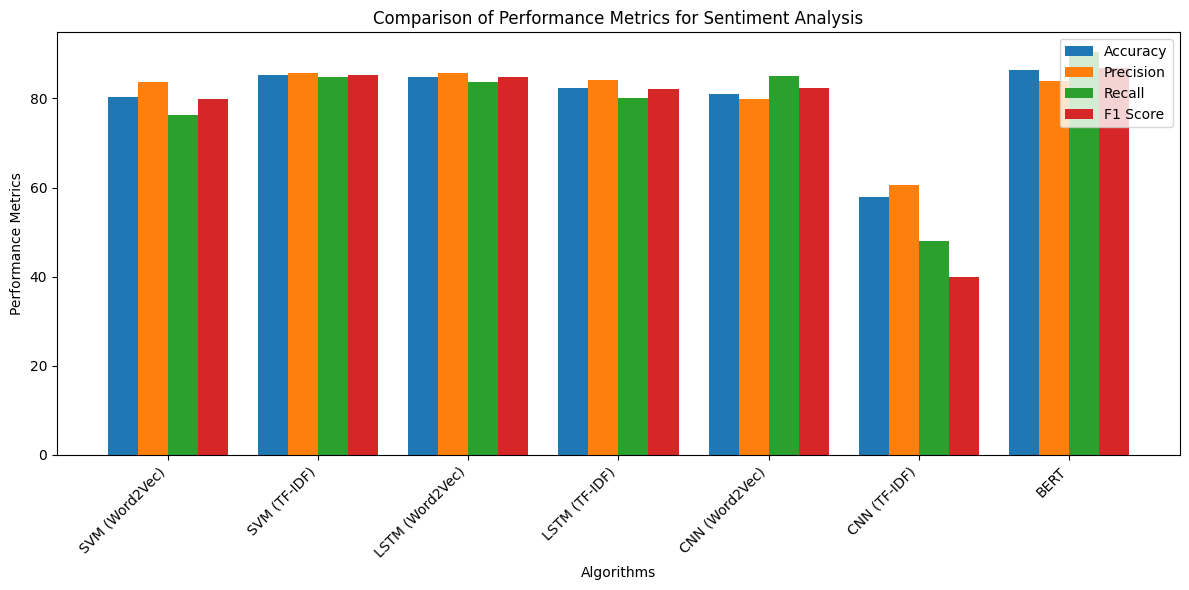

In [ ]:
# Plot the bar graph
fig, ax = plt.subplots(figsize=(12, 6))
width = 0.2
x = np.arange(len(algorithms))

ax.bar(x - 1.5 * width, accuracy, width, label='Accuracy')
ax.bar(x - 0.5 * width, precision, width, label='Precision')
ax.bar(x + 0.5 * width, recall, width, label='Recall')
ax.bar(x + 1.5 * width, f1, width, label='F1 Score')

ax.set_xticks(x)
ax.set_xticklabels(algorithms, rotation=45, ha='right')
ax.set_xlabel('Algorithms')
ax.set_ylabel('Performance Metrics')
ax.set_title('Comparison of Performance Metrics for Sentiment Analysis')
ax.legend()

plt.tight_layout()
plt.show()

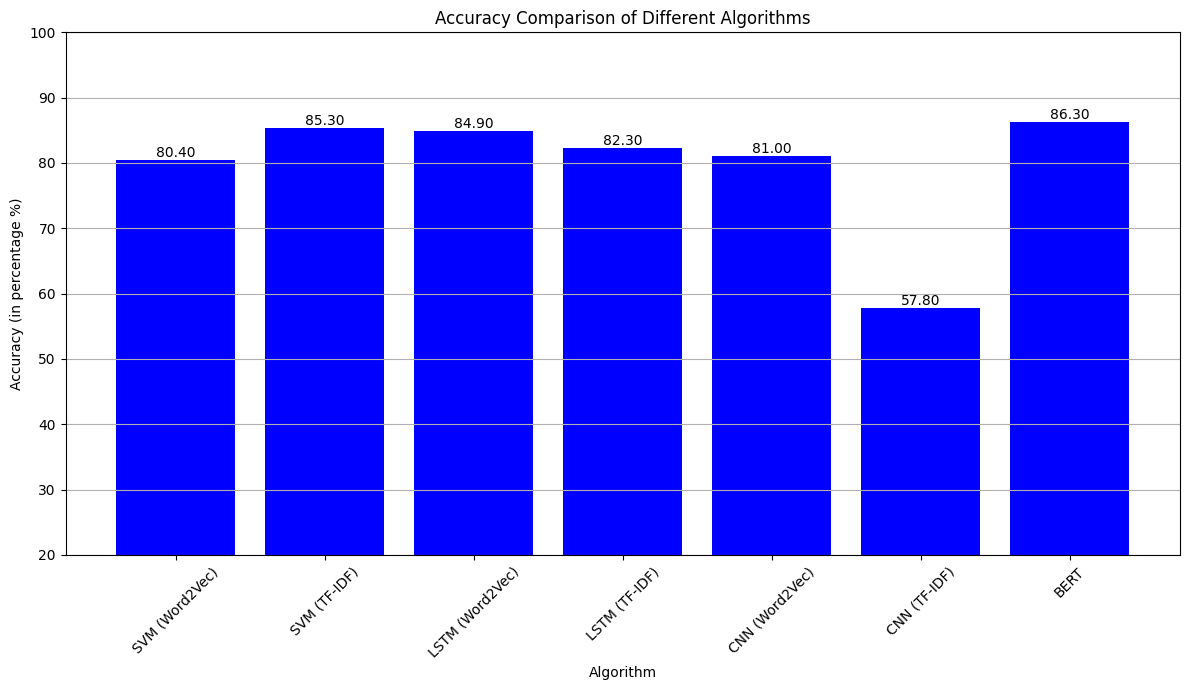

In [ ]:
algorithms = ['SVM (Word2Vec)', 'SVM (TF-IDF)', 'LSTM (Word2Vec)' ,'LSTM (TF-IDF)', 'CNN (Word2Vec)', 'CNN (TF-IDF)', 'BERT']
accuracy = accuracy = [svm_word2vec_accuracy, svm_tfidf_accuracy,lstm_word2vec_accuracy, lstm_tfidf_accuracy,cnn_word2vec_accuracy,cnn_tfidf_accuracy, bert_accuracy]

# Create a line graph to compare the accuracies
plt.figure(figsize=(12, 7))


bars = plt.bar(algorithms, accuracy, color='b')

plt.title('Accuracy Comparison of Different Algorithms')
plt.xlabel('Algorithm')
plt.ylabel('Accuracy (in percentage %)')
plt.xticks(rotation=45)

# Add accuracy values on top of each bar
for bar, acc in zip(bars, accuracy):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{acc:.2f}', ha='center', va='bottom')


plt.ylim(20, 100)
plt.grid(axis='y')
plt.tight_layout()
plt.show()